##  Calibration of the non-age-stratified deterministic model

# Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google, sciensano, polymod, parameters
from covid19model.visualization import output
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Load data and parameters

In [65]:
params = parameters.get_COVID19_SEIRD_parameters(stratified=False)

In [6]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices()

In [70]:
initN = np.array([initN.sum()])

In [9]:
sciensano_data = sciensano.get_sciensano_COVID19_data(update=False)
df_google = google.get_google_mobility_data(update=False)

# Initialise model

In [72]:
levels = initN.size
initial_states = {'S': initN, 'E': np.ones(levels)}

In [73]:
model = models.COVID19_SEIRD(initial_states, params)

In [74]:
# -> user runs a simulation for a defined time period
time = [0, 200]
out = model.sim(time)

In [75]:
out.parameters['beta']

0.03492

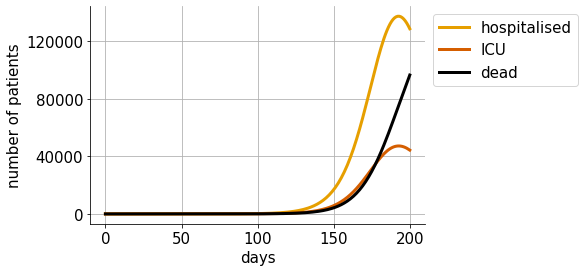

In [76]:
output.infected(out)

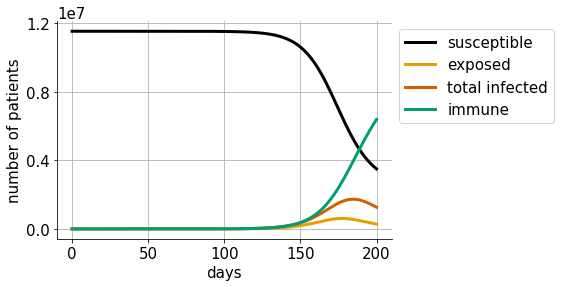

In [77]:
output.population_status(out)

## Initialise old model

In [ ]:
model = models.SEIRSAgeModel(initN   = np.array([11.43e6]),         #16x0 numpy array
                                     beta    = 0.0622, # probability of infection when encountering infected person
                                     sigma   = 3.2, # latent period
                                     omega   = 2.0, # pre-symptomatic infectious period
                                     Nc = np.array([11.2]), #must be a numpy array; average number of human-to-human interactions per day
                                     a = 0.43, # probability of an asymptotic (supermild) infection
                                     m = 1-0.43, # probability of a mild infection
                                     h = 0.20, # probability of hospitalisation for a mild infection
                                     c = 2/3, # probability of hospitalisation in cohort
                                     mi = 1/6, # probability of hospitalisation in midcare
                                     da = 7, # days of infection when asymptomatic (supermild)
                                     dm = 7, # days of infection when mild
                                     dc = 6.5,
                                     dmi = 8,
                                     dICU = 8,
                                     dICUrec = 6.5,
                                     dmirec = 6.5,
                                     dhospital = 7.5, # days before reaching the hospital when heavy or critical
                                     #m0 = np.transpose(np.array([0.000094,0.00022,0.00091,0.0018,0.004,0.013,0.046,0.098,0.18])), # mortality in ICU
                                     m0 = np.ones(1)*0.50,
                                     maxICU = 2000,
                                     totalTests = 0,
                                     psi_FP = 0, # probability of a false positive
                                     psi_PP = 1, # probability of a correct test
                                     dq = 14, # days in quarantaine                          
                                     initE = np.array([1]),
                                     initI = np.zeros(1),
                                     initA = np.zeros(1), 
                                     initM = np.zeros(1),
                                     initC = np.zeros(1),
                                     initCmirec = np.zeros(1),
                                     initCicurec = np.zeros(1),
                                     initMi = np.zeros(1),
                                     initICU = np.zeros(1),
                                     initR = np.zeros(1),
                                     initD = np.zeros(1),
                                     initSQ = np.zeros(1),
                                     initEQ = np.zeros(1),
                                     initIQ = np.zeros(1),
                                     initAQ = np.zeros(1),
                                     initMQ = np.zeros(1),
                                     initRQ = np.zeros(1),
                                     monteCarlo = False,
                                     n_samples = 1,
                            )

### Scrape high-level Sciensano data

In [ ]:
index,startdate,ICUvect,hospital = sciensano.get_sciensano_data()

### Perform calibration

In [ ]:
bounds

In [ ]:
calib_data

In [ ]:
# vector with dates
calib_period=pd.date_range(startdate, freq='D', periods=7)# calibrate on first 7 days
# data series used to calibrate model must be given to function 'plotFit' as a list
calib_data=[np.transpose(ICUvect[:,0:len(calib_period)]),np.transpose(hospital[:,0:len(calib_period)])]
# set optimisation settings
parNames = ['beta'] # must be a list!
positions = [np.array([5,6]),np.array([4,5,6])] # must be a list!
bounds=((10,60),(0.01,0.12)) # must be a list!
weights = np.array([0,1])
# run optimisation
theta = model.fit(calib_data,parNames,positions,bounds,weights,setvar=True,maxiter=30,popsize=60)

In [ ]:
model.LSQ()

In [ ]:
from covid19model.optimization import pso
import multiprocessing


In [ ]:
Nc

In [ ]:
popsize=60
maxiter = 30
p_hat, obj_fun_val, pars_final_swarm, obj_fun_val_final_swarm = pso.pso(model.LSQ, bounds, args=(calib_data,parNames,positions,weights), swarmsize=popsize, maxiter=maxiter,
                                                                                   processes=multiprocessing.cpu_count(),minfunc=1e-9, minstep=1e-9,debug=True, particle_output=True)
        

In [ ]:
## calibrated parameters (Verity et al.)
model.extraTime = 37.45862918
model.beta = 0.04800026

In [ ]:
# plot result
model.plotFit(calib_period,calib_data,positions,modelClr=['red','orange'],legendText=('ICU (model)','Hospitalized (model)','ICU (data)','Hospitalized (data)'),titleText='Belgium')

Slight underestimation of hospitalizations, most likely due to the fact that residence times in the hospital differ from the values used in our model. Using the UZ Ghent data to estimate distributions and incorporating this uncertainty will surely fix this in the future.

### Sample from the posterior distribution of beta (uncertainty analysis)

For now, the high-level python package `pyMC3` is used to sample from the posterior distribution of $\beta$. However, due to the high level nature of `pyMC3` it is hard to perform an elegant coupling with the BIOMATH covid-19 model. Because the parameter $\beta$ and the excess time $t_e$ are correlated, we fix the $t_e$ estimate obtained from MLE during the sampling procedure to avoid having a bi- or trimodal distributions for $\beta$.

In [ ]:
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

In [ ]:
n=theano.shared(float(ICUvect[:,0:idx].size))

@as_op(itypes=[tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def couple2COVID19MODEL(beta,n):
    model.beta = beta
    T = n+model.extraTime-1
    model.sim(T)
    out = (model.sumS,model.sumE,model.sumA,model.sumM,model.sumCtot,model.sumMi,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ)
    positions=np.array([5,6])
    for i in range(int(n)):
        som = 0
        for j in positions:
            som = som + np.mean(out[j],axis=1).reshape(np.mean(out[j],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

with pm.Model() as COVID19MODEL:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=model.beta, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=20)

    mu = couple2COVID19MODEL(beta,n)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=ICUvect[:,0:idx].flatten())

In [ ]:
# initial estimate to depart sampling from
map_estimate = pm.find_MAP(model=COVID19MODEL, method='L-BFGS-B',tol=1e-12)
map_estimate

**Opgelet: map_estimate past model.beta aan... niet zeker of dat de bedoeling is?**

In [ ]:
with COVID19MODEL:

    # draw 1000 posterior samples
    trace = pm.sample(500,start=map_estimate,step=pm.Slice(),cores=4)#,cores=12

**trace opslaan!!**

In [ ]:
pm.traceplot(trace,varnames=['beta','sigma'])

### Scenarios


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICUvect),np.transpose(hospital)]
# vector with dates
index=pd.date_range(startdate, freq='D', periods=ICUvect.size)
print(index[2],index[50],index[57],index[-1])

The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [ ]:
sigma = 0.2 # prevention measure

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

In [ ]:
#dates,retail_recreation,grocery,parks,transport,work,residential=google.get_google_mobility_data()

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [ ]:
# Create a dictionary of past policies
pastPolicy = {'t':       [7,50,57], 
              'Nc':      [0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          # 70 percent reduction in work --> from data gert peersman,
                          # 70 percent reduction in transit --> google community mobility report
                          0.3*Nc_home+sigma*((1-0.40)*Nc_work+(1-0.50)*Nc_transport),
                          # rule of four: sigma increases
                          # 40 percent reduction in work --> google covid mobility reports
                          # 50 percent reduction in transit --> google covid mobility reports (Contact Koen Schoors for data De Lijn!)
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.45)*Nc_transport+(1-0.50)*Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 30 percent reduction in work --> Google
                          # 45 percent reduction in transit --> Google
                          # All ages up untill 12 years back to school --> roughly 50 percent of schools back open
                          # retail & recreation back to 40 percent --> Google mobility report --> assume both leisure and others
                         ]
              }

In [ ]:
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=None,trace=None,T_extra=7,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename=None)

In [ ]:
# Create a dictionary of future policies
# starts day after last datapoint
futurePolicy = {'t':     [3,18], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma*((1-0.20)*Nc_work+(1-0.40)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 20 percent reduction in work --> If current trend in Google reports persists
                          # 40 percent reduction in transit --> If current trend in Google reports persists
                          # All ages back to school --> a lot of media attention to re-open schools at this point...
                          # retail & recreation still at 40 percent --> Google mobility report --> maybe it's going more up
                          0.5*Nc_home+sigma*((1-0.20)*Nc_work+(1-0.50)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others)
                          # Phase 3 of lockdown release: will we be able to see more friends? Increase in sigma.
                          # From hereon: scenarios,
                          
                         ],
              }

In [ ]:
t_data = pd.date_range(startdate, freq='D', periods=data[0].size)

In [ ]:
T_extra = 14

In [ ]:
T = len(t_data) + model.extraTime - 1 + int(T_extra)

In [ ]:
t_data = pd.date_range(startDate, freq='D', periods=data[0].size)
    T = len(t_data) + self.extraTime - 1 + int(T_extra) # number of datapoints

    # make a deepcopy --> if you modify a python dictionary in a function it will be modified globally
    dict1_orig = copy.deepcopy(pastPolicy)
    dict2_orig = copy.deepcopy(futurePolicy)

    # add estimated extraTime to past policy vector
    for i in range(len(dict1_orig['t'])):
        dict1_orig['t'][i] = dict1_orig['t'][i] + self.extraTime - 1

    # Create a merged dictionary accounting for estimated 'extraTime'
    if futurePolicy is not None:
        chk = self.mergeDict((T-int(T_extra)-1),dict1_orig,dict2_orig)
        T = chk['t'][-1]+int(T_extra)
    else:
        chk = pastPolicy
    # ------------------
    # Prepare simulation
    # ------------------
    # reset all numX
    self.reset()

    # ------------------
    # Perform simulation
    # ------------------
    self.sim(T,checkpoints=chk,trace=trace)
    # tuple the results, this is necessary to use the positions index
    out = (self.sumS,self.sumE,self.sumA,self.sumM,self.sumCtot,self.sumMi,self.sumICU,self.sumR,self.sumD,self.sumSQ,self.sumEQ,self.sumAQ,self.sumMQ,self.sumRQ)

    # -----------
    # Plot result
    # -----------
    # Create shifted index vector using self.extraTime
    t_acc = pd.date_range(startDate,freq='D',periods=T+1)-datetime.timedelta(days=self.extraTime-1)
    # Plot figure
    fig, ax = plt.subplots()
    # Plot data
    for i in range(len(data)):
        ax.scatter(t_data,data[i],color="black",marker=dataMkr[i])
    # Plot model prediction
    for i in range(len(data)):
        ymodel = 0
        for j in positions[i]:
            ymodel = ymodel + out[j]
        ax.plot(t_acc,numpy.mean(ymodel,axis=1),'--',color=modelClr[i])
        ax.fill_between(t_acc,numpy.percentile(ymodel,95,axis=1),
             numpy.percentile(ymodel,5,axis=1),color=modelClr[i],alpha=0.2)
    # Attributes
    if legendText is not None:
        ax.legend(legendText, loc="upper left", bbox_to_anchor=(1,1))
    if titleText is not None:
        ax.set_title(titleText,{'fontsize':18})
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    ax.set_xlim( t_acc[self.extraTime-3], pd.to_datetime(t_acc[-1]))
    ax.set_ylabel('number of patients')
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    # enable the grid
    plt.grid(True)
    # To specify the number of ticks on both or any single axes
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    if filename is not None:
        plt.savefig(filename,dpi=600,bbox_inches='tight')
    if getfig:
        return fig, ax
    else:
        plt.show()


In [ ]:
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy,trace=None,T_extra=7,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename=None)

In [ ]:
# Create a dictionary of future policies
futurePolicy_S1 = {'t':     [3,18], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma2*((1-0.20)*Nc_work+(1-0.40)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          0.5*Nc_home+sigma3*((1-0.20)*Nc_work+(1-0.50)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          0.5*Nc_home+sigma3*((1-0.20)*Nc_work+(1-0.50)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others)

                         ],
              }

In [ ]:
pd.to_datetime('2020-05-21')+pd.Timedelta('18days')